In [1]:
%cd git/hist_future_hail/

/home/561/tr2908/git/hist_future_hail


In [2]:
import sys
import xarray
import numpy as np
import cartopy.crs as ccrs
from importlib import reload
import matplotlib.pyplot as plt
import modules.hist_fut_hail as hf
from dask.distributed import Client
import glob
import seaborn as sns

In [3]:
cache_dir = '/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/results_cache'
dat = []
for file in glob.glob(cache_dir+'/[M,P,B,S]*.nc'):
    print(file)
    d = xarray.open_dataset(file, chunks=-1)
    d['latitude'] = d.latitude.expand_dims({'city': d.city})
    d['longitude'] = d.longitude.expand_dims({'city': d.city})
    dat.append(d)

/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/results_cache/Melbourne_SSP2-4.5_hourly_stats.nc
/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/results_cache/Sydney_SSP2-4.5_hourly_stats.nc
/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/results_cache/Brisbane_Historical_hourly_stats.nc
/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/results_cache/Melbourne_Historical_hourly_stats.nc
/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/results_cache/Brisbane_SSP2-4.5_hourly_stats.nc
/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/results_cache/Perth_SSP2-4.5_hourly_stats.nc
/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/results_cache/Perth_Historical_hourly_stats.nc
/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/results_cache/Sydney_Historical_hourly_stats.nc


In [4]:
dat = xarray.merge(dat)
dat = dat.assign_coords({'sim': ['Historical', '+2.8 C']})

In [5]:
#dat['mixed_100_cape_quantile'] = dat.mixed_100_cape_quantile.where(dat.mixed_100_cape_quantile != 0)

In [10]:
def plot_dist_comparison(dat, variables, varnames, quantiles=None,
                         figsize=(12,6), xlims=None, log=None):
    """
    Plot a distribution comparison between simulations.

    Arguments:
        dat: Data to use for the plots.
        variables: The variables to plot for (one row per variable).
        quantiles: If required, the quantile to select.
        varnames: Pretty-print name of variables for axis labels.
        figsize: Figure width, height.
        xlims: Limit x axis extent?
        log: X axis in log scale?
    """

    fig, axs = plt.subplots(ncols=len(dat.city.values), nrows=len(variables), figsize=figsize, gridspec_kw={'hspace': 0.5})
    
    for v, var in enumerate(variables):
        for i, city in enumerate(dat.city.values):
        
            if quantiles[v] is not None:
                d = dat.sel(city=city, quantile=quantiles[v])[variables[v]]
            else:
                d = dat.sel(city=city)[variables[v]]
                assert not 'quantile' in d.dims, 'Quantile needs to be specified for this variable.'
                    
            #sns.kdeplot(data=d.to_dataframe(), x=variables[v], hue='sim', fill='sim', ax=axs[v, i], common_norm=True)
            sns.violinplot(data=d.to_dataframe(), x=variables[v], hue='sim', fill='sim', y='sim', ax=axs[v, i])

            if v == 0:
                axs[v, i].set_title(city)
            axs[v, i].set_xlabel(varnames[v])

            if not xlims is None:
                axs[v, i].set_xlim(xlims[v])
            #axs[v, i].get_legend().set_title('')

            if not log is None:
                if log[v]:
                    axs[v, i].set_xscale('log')

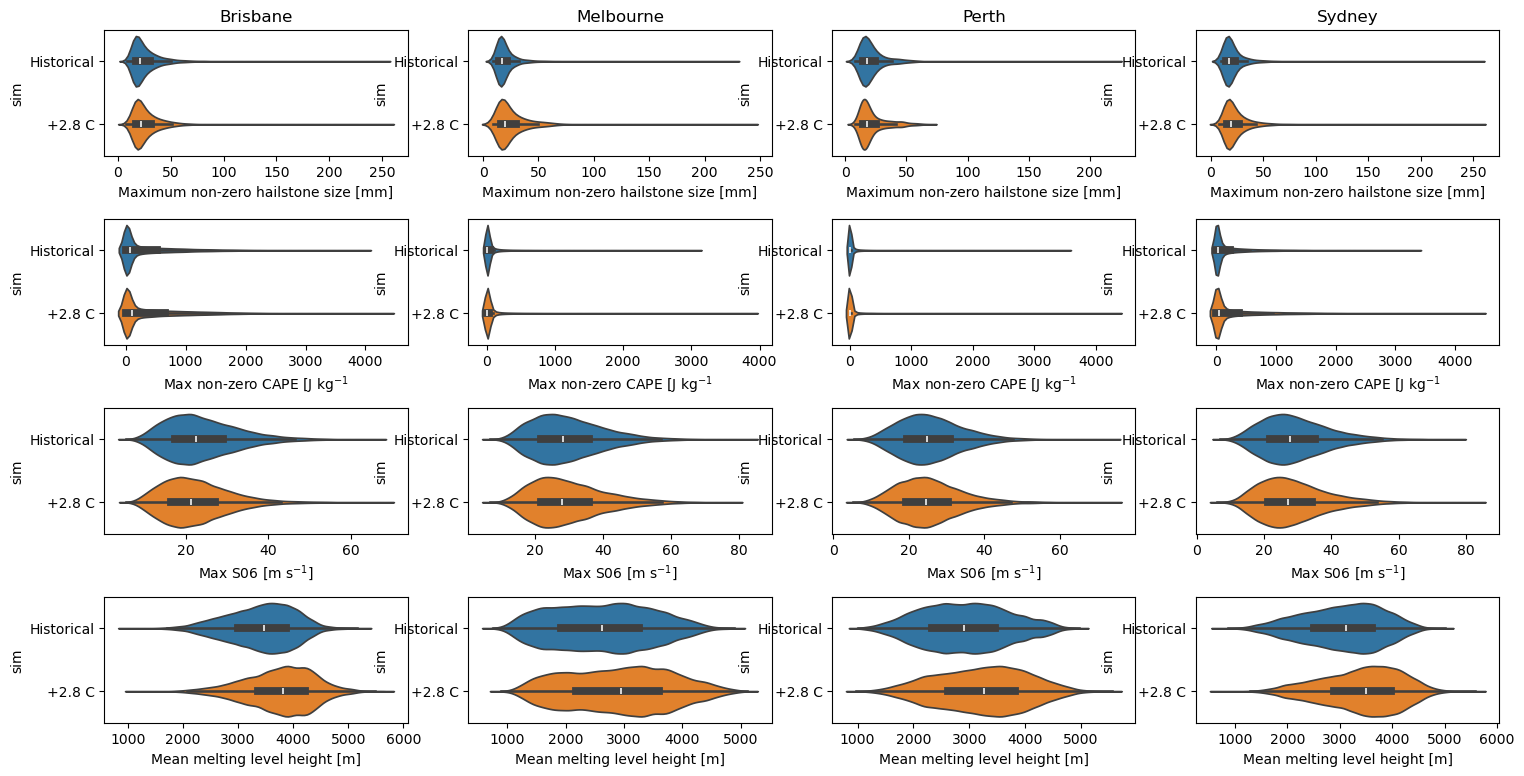

In [11]:
plot_dist_comparison(dat=dat, 
                     variables=['hailcast_diam_max_quantile', 'mixed_100_cape_quantile', 'shear_magnitude_quantile', 'melting_level_mean'], 
                     varnames=['Maximum non-zero hailstone size [mm]', 'Max non-zero CAPE [J kg$^{-1}$', 'Max S06 [m s$^{-1}$]', 'Mean melting level height [m]'],
                     quantiles=[1, 1, 1, None], 
                     log=[False, False, False, False],
                     figsize=(18, 9))